In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from prefect.blocks.system import Secret
from catnip.fla_redshift import FLA_Redshift
from typing import Dict
from concurrent.futures import ThreadPoolExecutor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from collections import Counter

from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
def get_redshift_credentials() -> Dict:

    cred_dict = {
        "dbname": Secret.load("stellar-redshift-db-name").get(),
        "host": Secret.load("stellar-redshift-host").get(),
        "port": 5439,
        "user": Secret.load("stellar-redshift-user-name").get(),
        "password": Secret.load("stellar-redshift-password").get(),

        "aws_access_key_id": Secret.load("fla-s3-aws-access-key-id-east-1").get(),
        "aws_secret_access_key": Secret.load("fla-s3-aws-secret-access-key-east-1").get(),
        "bucket": Secret.load("fla-s3-bucket-name-east-1").get(),
        "subdirectory": "us-east-1",

        "verbose": False,
    }

    return cred_dict

with ThreadPoolExecutor(1) as pool:
    rs_creds = pool.submit(lambda: get_redshift_credentials()).result()

In [18]:
q = """
    with seats as
        (select 
            distinct seat_id, pc_one
        from 
            custom.cth_manifest_2223 ),

    dates as
        (select 
            event_date
        from 
            custom.cth_game_descriptions
        where 
            season = '2022-23' and is_regular_season = 1),

    other as
        (select 
            event_date, section_name, row_name, seat,
            cast(section_name as varchar)+'-'+cast(row_name as varchar)+'-'+cast(seat as varchar) as seat_id,block_purchase_price, ticket_type
        from 
            custom.cth_ticket_expanded_all),

    base as
        (select 
            *
        from 
            dates
        cross 
            join seats)

    select 
        base.event_date, tier, is_premier, original_six_plus_extra, base.seat_id, abbreviation, pc_one,
            CASE
                WHEN pc_one in ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', '1', '2', '3', '4', '5', '6', '7', '8')
                    THEN 'Lowers'
                WHEN pc_one in ('K', 'L', 'M') THEN 'Clubs'
                WHEN pc_one in ('N', 'O', 'P', 'Q', 'R', 'S', 'T') THEN 'Uppers'
                WHEN pc_one in ('U', 'V', 'W') THEN 'Suites'
                WHEN pc_one in ('X') THEN 'Amerant'
                WHEN pc_one in ('Y') THEN 'Loft'
                WHEN pc_one in ('Z') THEN 'Corona'
                ELSE 'unknown'
                END AS location,
        CASE
            when block_purchase_price > 0 then block_purchase_price
            else 0
        end as block_purchase_price,
        CASE
            when ticket_type IS NOT NULL then ticket_type
            else 'Not Sold'
        end as ticket_type_final,
        CASE
            when ticket_type_final in ('Full', 'Annual Suites', 'Premier', 'Flex', 'Quarter', 'Sponsor', 'Trade') then 'Plans'
            when ticket_type_final in ('Not Sold') then 'Not Sold'
            else 'Nightly'
        end as ticket_type_group
    from 
        base
    left join 
        other on base.event_date = other.event_date and base.seat_id = other.seat_id
    left join 
        custom.cth_game_descriptions on base.event_date = cth_game_descriptions.event_date
    order by 
        base.event_date, base.seat_id
    """

df = FLA_Redshift(**rs_creds).query_warehouse(sql_string=q)

In [19]:
df['dow'] = [datetime.weekday(datetime.strptime(x, "%Y-%m-%d")) for x in df['event_date']]
df['tier_num'] = df.apply(lambda row: 5 if row['tier'] == 'A' else (4 if row['tier'] == 'B' else (3 if row['tier'] == 'C' else (2 if row['tier'] == 'D' else 1))), axis = 1)

df_groupby = df.groupby(by = ['event_date', 'pc_one'])['seat_id'].count()

df_sold = df[~df.ticket_type_final.isin(['Not Sold'])]

df_sold_groupby = df_sold.groupby(by = ['event_date', 'pc_one'])['seat_id'].count()

df_sold_non_nightly = df[~df.ticket_type_group.isin(['Not Sold'])]

df_groupby_2 = df_sold_non_nightly.groupby(by = ['event_date', 'pc_one'])['seat_id'].count()
df_by_pc_2 = df_groupby_2.to_frame().rename(columns = {'seat_id' : 'non_nightly_seats'})
df_by_pc_2.reset_index(inplace = True)


df_by_pc = df_groupby.to_frame().rename(columns = {'seat_id' : 'total_seats'})
df_by_pc.reset_index(inplace = True)
df_sold_by_pc = df_sold_groupby.to_frame().rename(columns = {'seat_id' : 'sold_seats'})
df_sold_by_pc.reset_index(inplace = True)

df_merge = df_by_pc.merge(right = df_sold_by_pc, how = 'left', on = ['event_date', 'pc_one'])

df_merge['sell_thru'] = [x/y for x,y in zip(df_merge['sold_seats'], df_merge['total_seats'])]

df_merge['new_sell_thru'] = df_merge.apply(lambda row: row['sell_thru'] if row['sell_thru'] == 1 else (1.1*row['sell_thru'] if row['sell_thru'] < 0.7 else (1.05*row['sell_thru'] if 1.05*row['sell_thru'] < 1 else 1)), axis = 1)

df_merge['new_seats'] = [int((x*y)-z) for x,y,z in zip(df_merge['total_seats'], df_merge['new_sell_thru'], df_merge['sold_seats'])]
df_sold_by_pc_nightly = df[(df['ticket_type_group'] == 'Nightly') & (df['block_purchase_price'] > 0)]

df_merge_2 = df_sold_by_pc_nightly.groupby(by = ['tier', 'pc_one'])['block_purchase_price'].mean()
df_merge_2 = df_merge_2.to_frame().rename(columns = {'seat_id' : 'total_seats'})
df_merge_2.reset_index(inplace = True)

q = """
    select distinct event_date, tier
    from custom.cth_game_descriptions
    where season = '2022-23'
    and tier not like '%P%'
    and tier not like '%S%'
    """

df2 = FLA_Redshift(**rs_creds).query_warehouse(sql_string=q)

df_merge = df_merge.merge(right = df2, how = 'left', on = ['event_date'])

df_merge = df_merge.merge(right = df_merge_2, how = 'left', on = ['tier', 'pc_one'])
df_merge = df_merge.merge(right = df_by_pc_2, how = 'left', on = ['event_date', 'pc_one'])

df_merge['leftover_seats'] = [x-y for x,y in zip(df_merge['total_seats'], df_merge ['non_nightly_seats'])]

df_merge['add_rev'] = [x*y for x,y in zip(df_merge['leftover_seats'], df_merge['block_purchase_price'])]

df_merge_2 = df_sold.groupby(by = ['event_date'])['block_purchase_price'].sum()

    # print(df_merge.groupby(by = ['event_date'])['add_rev'].sum())

pcs = sorted(df['pc_one'].unique())
pc_dict = dict((value,count) for count, value in enumerate(pcs))
df['pc_num'] = df.apply(lambda row: pc_dict[row['pc_one']], axis = 1)

In [104]:
df_unique = df.groupby(by = ['seat_id'])['ticket_type_final'].unique()
df_unique = df_unique.to_frame()
df_unique.reset_index(inplace = True)
df_unique['qqq'] = df_unique.apply(
    lambda row: 1 if np.array_equal(row['ticket_type_final'], ['Full']) or np.array_equal(row['ticket_type_final'], ['Annual Suites']) 
    or np.array_equal(row['ticket_type_final'], ['Sponsor']) or np.array_equal(row['ticket_type_final'], ['Trade']) else 0, axis = 1)
df_unique[df_unique['qqq'] == 0]

,seat_id,ticket_type_final,ppp
9,101-10-5,"[Full, Not Sold]",0
10,101-10-6,"[Full, Not Sold]",0
14,101-11-1,"[Full, Premier, Singles, Flex]",0
20,101-11-2,"[Full, Premier, Singles, Flex]",0
23,101-11-5,"[Premier, Not Sold, Singles, Groups, Full]",0
...,...,...,...
19926,SL49-SRO-7,"[Not Sold, Nightly Suites]",0
19932,SL50-1-6,[Not Sold],0
19938,SL50-2-6,[Not Sold],0
19949,SL50-SRO-6,[Not Sold],0


In [20]:
X = df[['dow', 'tier_num', 'pc_num', 'is_premier', 'original_six_plus_extra']]
y = df[['ticket_type_group']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1993)
ss = StandardScaler()
x_train_scaled = ss.fit_transform(X_train)
x_test_scaled = ss.fit_transform(X_test)

In [21]:
print(Counter(y_train['ticket_type_group'].tolist()).keys())
print(Counter(y_train['ticket_type_group'].tolist()).values())

dict_keys(['Nightly', 'Not Sold', 'Plans'])
dict_values([197874, 93502, 256677])


In [22]:
df_not_sold = df[df['ticket_type_group'] == 'Not Sold']
Xn = df_not_sold[['dow', 'tier_num', 'pc_num', 'is_premier', 'original_six_plus_extra']]
xn_train_scaled = ss.fit_transform(Xn)

c:\Users\riffere\Documents\pandas_party\venv\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.6191773423373287


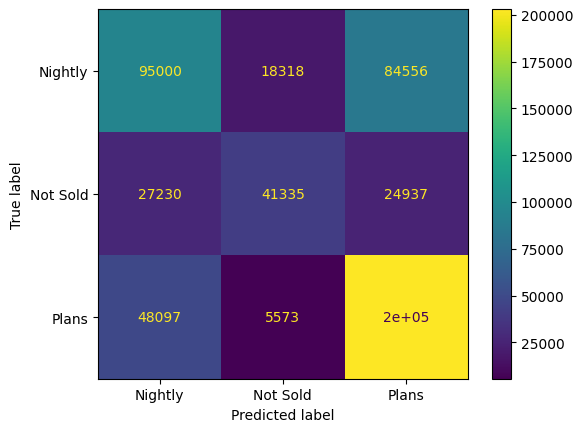

In [23]:
# RFC
clf = RandomForestClassifier(random_state = 1993) # 7.7% different, 55.6% accurate
clf.fit(x_train_scaled, y_train)

predicted = clf.predict(x_train_scaled)
cm = confusion_matrix(y_train.values,predicted, labels = ['Nightly', 'Not Sold', 'Plans'])
print(accuracy_score(y_train.values,predicted))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Nightly','Not Sold', 'Plans'])
disp.plot()
plt.show()

In [48]:
df1 = pd.DataFrame(data = X_train)
df2 = pd.DataFrame(data = predicted, columns = ['predicted'])
df1 = pd.concat([df1, y_train], axis = 1).reset_index(drop = True)
df1 = pd.concat([df1, df2], axis = 1)
df1 = df1[df1['ticket_type_group'] == 'Not Sold']
print(Counter(df1['predicted'].tolist()).keys())
print(Counter(df1['predicted'].tolist()).values())

dict_keys(['Not Sold', 'Nightly', 'Plans'])
dict_values([41335, 27230, 24937])


In [12]:
predicted = clf.predict(xn_train_scaled)
print(Counter(predicted.tolist()).keys())
print(Counter(predicted.tolist()).values())

dict_keys(['Plans', 'Nightly', 'Not Sold'])
dict_values([82683, 35626, 21416])


c:\Users\riffere\Documents\pandas_party\venv\Lib\site-packages\sklearn\neighbors\_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.566304718704213


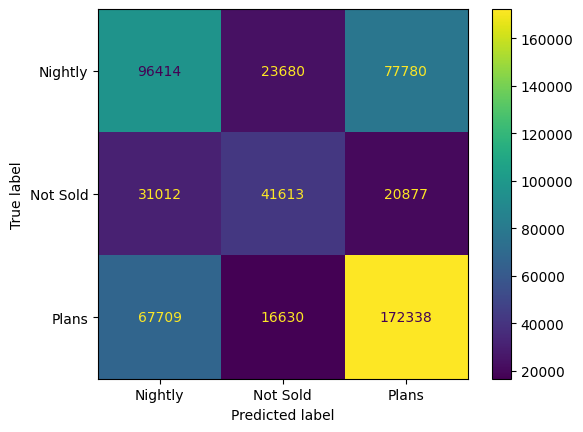

In [12]:
# KNN
knn = KNeighborsClassifier(weights = 'distance') # 11.6% different, 49.4% accurate
knn.fit(x_train_scaled, y_train)

predicted = knn.predict(x_train_scaled)
cm = confusion_matrix(y_train.values,predicted, labels = ['Nightly', 'Not Sold', 'Plans'])
print(accuracy_score(y_train.values,predicted))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Nightly','Not Sold', 'Plans'])
disp.plot()
plt.show()

c:\Users\riffere\Documents\pandas_party\venv\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.47658164447599044


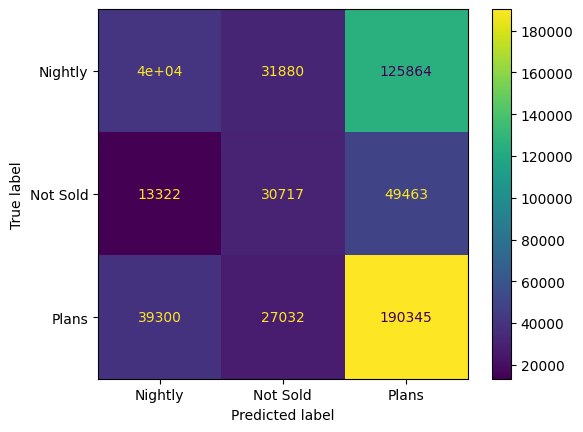

In [13]:
# bayes
knn = GaussianNB() # 11.6% different, 49.4% accurate
knn.fit(x_train_scaled, y_train)

predicted = knn.predict(x_train_scaled)
cm = confusion_matrix(y_train.values,predicted, labels = ['Nightly','Not Sold', 'Plans',])
print(accuracy_score(y_train.values,predicted))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Nightly','Not Sold', 'Plans'])
disp.plot()
plt.show()

c:\Users\riffere\Documents\pandas_party\venv\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.4727042822500744


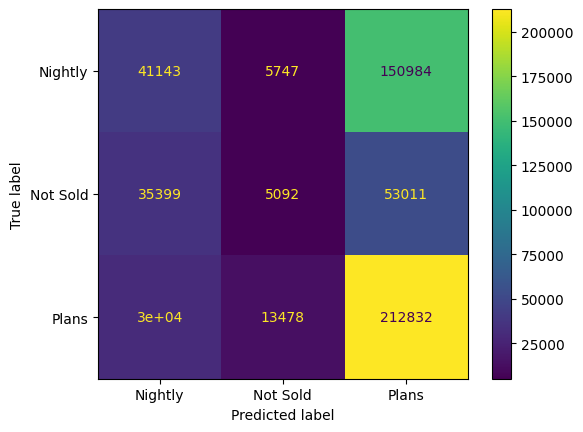

In [14]:
# bayes
knn = LinearDiscriminantAnalysis() # 11.6% different, 49.4% accurate
knn.fit(x_train_scaled, y_train)

predicted = knn.predict(x_train_scaled)
cm = confusion_matrix(y_train.values,predicted, labels = ['Nightly','Not Sold', 'Plans'])
print(accuracy_score(y_train.values,predicted))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Nightly','Not Sold', 'Plans'])
disp.plot()
plt.show()